In [183]:
import pandas as pd
import numpy as np
import sklearn.model_selection as sm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

tr_path = 'covid.train.csv'
tt_path = 'covid.test.csv'
config = {'batch_size': 80,
    'save_path':'models/covid-model',
    'early_stop_count':220,
    'epochs':2000}

In [184]:
# data = pd.read_csv(tr_path).drop(['id'], axis=1)
# target =  data[['tested_positive.2']]
# print(target.shape)
# data.head(3)
# data_corr = data.iloc[:,40:].corr()
# data_col  = data_corr['tested_positive.2']
# target_col = data_col[data_col > 0.8]
# target_col = target_col.drop(['tested_positive.2'])
# features = target_col.index.tolist()
# # print(features)
# data = data[features]
# data.head(3)


#### 定义数据集

In [185]:


class COVID19DataSet(Dataset):
    def __init__(self, model, path):
        data = pd.read_csv(path).drop(['id'],axis=1)
        # print('读取数据示例:')
        # print(data.head(2))
        data_corr = data.iloc[:,40:].corr()
        data_col  = data_corr['tested_positive.2']
        target_col = data_col[data_col > 0.8]
        features = target_col.index.tolist()
        data = data[features]
        self.model = model
        # data = pd.DataFrame(data)
        if model == 'test':
            # print('test 模型样本数据: ')
            # print(data.head(3))
            self.data = torch.FloatTensor(data)
        else:
            train_data, valid_data = sm.train_test_split(data,test_size=0.25,random_state=249)
            train_data = pd.DataFrame(train_data)
            valid_data = pd.DataFrame(valid_data)
            if model == 'train':
                # print('train 模型样本数据: ')
                # print(train_data.head(3))
                self.target = torch.FloatTensor(np.array(train_data[['tested_positive.2']]))
                self.data = torch.FloatTensor(np.array(train_data[features]))
            elif model == 'valid':
                # print('valid 模型样本数据: ', valid_data.head(3))
                self.target = torch.FloatTensor(np.array(valid_data[['tested_positive.2']]))
                self.data = torch.FloatTensor(np.array(valid_data[features]))
            else:
                print('未知训练模型: {}、无数据加载!!!!'.format(model))
        self.dim = self.data.shape[1]
        print('完成数据加载、模型:{},数据量:{}'.format(model, len(self.data)))

    def __getitem__(self, index):
        if self.model == 'test':
            # 测试数据集不需要预测值
            return self.data[index]
        else:
            return self.data[index],self.target[index]

    def __len__(self):
        return len(self.data)
       

#### 数据集加载引擎

In [186]:
def load_data(model,path,batch_size,shuffle):
    dataset = COVID19DataSet(model,path)
    # shuffle 属性、Training: True Testing:  False
    return DataLoader(dataset,batch_size,shuffle)

#### 判断是否支持GPU

In [187]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else  'cpu'

#### 定义神经网络

In [188]:
class NeturalNet(nn.Module):
    def __init__(self, input_dim):
        super(NeturalNet,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 68),
            nn.ReLU(),
            nn.Linear(68,1)
        )
        self.criterion = nn.MSELoss(reduction='mean')
        
    def forward(self, x):
        return self.net(x)

    def loss_criterion(self,pred, target):
        # print('预测值: ', pred.size())
        # print('实际值:', target.size())
        return self.criterion(pred, target)


In [189]:
def valid_model(valid_set, model, device):
    model.eval()
    total_loss = 0
    for x,y in valid_set:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            mse_loss = model.loss_criterion(pred,y)
            total_loss += mse_loss.detach().cpu().numpy()
        return total_loss / len(valid_set.dataset)

#### 定义训练过程

In [190]:
def train_model(train_set, valid_set, model, device, config):
    epochs = config['epochs']
    optm = torch.optim.Adam(model.parameters(),lr=0.05)
    min_mse = 10000000
    epoch = 1
    loss_record = {'train':[],'valid':[]}
    early_stop = 0
    print(config['early_stop_count'])
    while epoch < epochs :
        model.train()
        for x, y in train_set:
            optm.zero_grad()
            x ,y= x.to(device),y.to(device)
            pred_y = model(x)
            mse_loss = model.loss_criterion(pred_y, y)
            mse_loss.backward()
            optm.step()
            loss_record['train'].append(mse_loss.detach().cpu().numpy())
            # 验证训练模型损失值
            valid_mse = valid_model(valid_set, model,device)
            if min_mse > valid_mse:
                min_mse = valid_mse
                torch.save(model.state_dict(),config['save_path'])
                early_stop = 0
                print('损失值降低、保存模型. epach:{},loss:{}'.format(epoch, min_mse))
            else:
                early_stop += 1
            epoch +=1
            loss_record['valid'].append(valid_mse)
            if early_stop > config['early_stop_count']:
                print('验证集损失平均值小于当前值次数达到:{}、提前停止训练. epach:{},loss:{}'.format(config['early_stop_count'],epoch, min_mse))
                return min_mse, loss_record

    print('完成模型训练,epach:{},loss:{}'.format(epoch, min_mse))
    return min_mse, loss_record

#### 加载数据

In [191]:
# shuffle 属性、Training: True Testing:  False
train_data = load_data('train',tr_path,config['batch_size'],shuffle=True)
vaild_data = load_data('valid',tr_path,config['batch_size'],shuffle=True)


完成数据加载、模型:train,数据量:2025
完成数据加载、模型:valid,数据量:675


#### 获取devcei类型: cpu or cuda 

In [192]:
device = get_device()

#### 加载模型

In [193]:
model = NeturalNet(train_data.dataset.dim)

#### 开始训练

In [194]:
min_loss, loss_record = train_model(train_data, vaild_data, model, device, config)

220
损失值降低、保存模型. epach:1,loss:0.5491222240306713
损失值降低、保存模型. epach:2,loss:0.09278153030960648
损失值降低、保存模型. epach:3,loss:0.046965874565972225
损失值降低、保存模型. epach:8,loss:0.038796943381980614
损失值降低、保存模型. epach:9,loss:0.017004275851779514
损失值降低、保存模型. epach:14,loss:0.016886620698151764
损失值降低、保存模型. epach:20,loss:0.013579501399287472
损失值降低、保存模型. epach:27,loss:0.011011953707094546
损失值降低、保存模型. epach:38,loss:0.00946067456845884
损失值降低、保存模型. epach:40,loss:0.008520520528157553
损失值降低、保存模型. epach:41,loss:0.006850995664243345
损失值降低、保存模型. epach:46,loss:0.006458569985848886
损失值降低、保存模型. epach:47,loss:0.00572565997088397
损失值降低、保存模型. epach:50,loss:0.005619588781286169
损失值降低、保存模型. epach:51,loss:0.004773524955466941
损失值降低、保存模型. epach:54,loss:0.003900088557490596
损失值降低、保存模型. epach:56,loss:0.003422228848492658
损失值降低、保存模型. epach:62,loss:0.0029231092664930556
损失值降低、保存模型. epach:63,loss:0.0028410093872635453
损失值降低、保存模型. epach:64,loss:0.002625160217285156
损失值降低、保存模型. epach:65,loss:0.002234487533569336
损失值降低、保存模型. epach

In [195]:
#### 绘制学习曲线

In [196]:
def plot_learn_curve(loss_record):
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['valid'])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['valid'], c='tab:cyan', label='valid')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of train')
    plt.legend()
    plt.show()

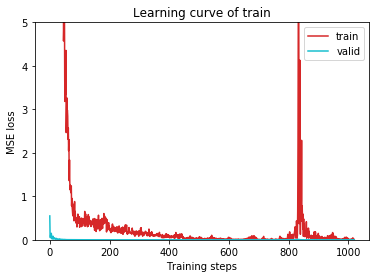

In [197]:
plot_learn_curve(loss_record)

#### 绘制预测曲线

In [198]:
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    plt.figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

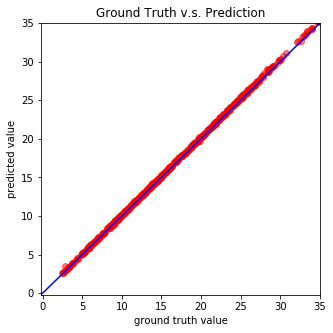

In [199]:
plot_pred(vaild_data,model,device,)